In [1]:
import toast
env = toast.Environment.get()
env.set_log_level("DEBUG")
print(env)
from toast.todmap import (
    TODSatellite,
    slew_precession_axis,
    OpPointingHpix,
    OpAccumDiag
)
from toast.map import (
    DistPixels
)
import toast.qarray as qa
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

<toast.Environment
  Source code version = bba9dd9.dev14
  Logging level = DEBUG
  Handling enabled for 0 signals:
  Max threads = 12
  MPI build disabled
  MPI runtime disabled
>


In [2]:
########################################################
# toast-lesson 方式にあう focal plane 作成
########################################################
import toml
def fake_focalplane(
    hardware,
):

    """Create a set of detectors from the hardware file.

    Args:
        hardware file

    Returns:
        (dict):  dictionary of detectors and their properties.

    """
    epsilon=0
    dict_toml = toml.load(open(hardware))
    dets = dict()
    for dname in dict_toml['detectors'] :  
        props = dict()
        quat=dict_toml['detectors'][dname]['quat']
        props["quat"] = np.array([np.float(x) for x in quat]) 
        props["epsilon"] = epsilon
        props["rate"] = sampling_rate
        bname=dict_toml['detectors'][dname]['band']
        props["fwhm"] = dict_toml['bands'][bname]['fwhm']
        props["bandcenter_ghz"] = dict_toml['bands'][bname]['center']
        props["bandwidth_ghz"] = dict_toml['bands'][bname]['bandwidth']
        props["NET"] = dict_toml['bands'][bname]['NET']
        props["alpha"] = dict_toml['bands'][bname]['alpha']
        props["fmin"] = dict_toml['bands'][bname]['fmin']
        props["fknee"] = dict_toml['bands'][bname]['fknee']
        #props["alpha"] = 0.0
        #props["fmin"] = 0.0
        #props["fknee"] = 0.0
        dets[dname] = props
    return dets

In [3]:
########################################################
# User-defined parameters
########################################################
# output dir
outdir='./maps/'
file_name="3hr_W_sorted_"
# Detector
samplerate = 19.5312283 # Hz
sampling_rate = samplerate
hardware="CR_sim01.toml"
# Scan
alpha = 0.0 # 45.0      # precession opening angle, degrees
beta = 50.0     # spin opening angle, degre
p_alpha = 0.0 # 192.348    # precession period, minutes
p_beta = 20.0     # spin period, minutes
hwprpm = 46.0      # HWP rotation in RPM

# Observation (in the unit of days).
# 1 obs = 1 day
input_file = "TOD_Samantha_3hr_W_sorted_all_channels.npz"
#input_file = "demod_test_1.npz"
obs_samples = int(len(np.load(input_file)["arr_0"]))#int(1 * 90*60 * samplerate)
nobs = 1 # days.
print(len(np.load(input_file)["arr_0"]))
# Map
nside = 256        # Healpix NSIDE

210960


In [4]:
########################################################
# Main routine
########################################################
# Default Comm (one group for this example)
comm = toast.Comm()

# Define focal plane.
fp = fake_focalplane(hardware=hardware)
detnames = list(sorted(fp.keys()))
detquat = {x: fp[x]["quat"] for x in detnames}

# Slew the precession axis so that it completes one circle
deg_per_day = 360.0 / 365.25#nobs

# Instantiate and append observations
data = toast.Data(comm)

In [5]:
for ob in range(nobs):
    obsname = "{:03d}".format(ob)
    obsfirst = 0 #ob * (obs_samples)# + 1)
    obsstart = 0 # .0 #1 * 3600.0
    tod = TODSatellite(
        comm.comm_group,
        detquat,
        obs_samples,
        firstsamp=obsfirst,
        firsttime=obsstart,
        rate=samplerate,
        spinperiod=p_beta,
        spinangle=beta,
        precperiod=p_alpha,
        precangle=alpha,
        coord="E",
        hwprpm=hwprpm
        )
    qprec = np.empty(4 * tod.local_samples[1], dtype=np.float64).reshape((-1, 4))
    slew_precession_axis(
        qprec,
        firstsamp=obsfirst,
        samplerate=samplerate,
        degday=deg_per_day,
    )

    tod.set_prec_axis(qprec=qprec)
    obs = dict()
    obs["tod"] = tod
    #obs["noise"] = noise
    data.obs.append(obs)

In [6]:
name = "signal"
toast.tod.OpCacheClear(name).exec(data)
#print("detectors are", tod.local_dets)
#print("---------")
# Add glitches
#prop=dict()
simCR = toast.tod.OpSimDataByDet()
toast.tod.OpCacheClear("signal").exec(data)
simCR.exec(input_file,data)

In [7]:
name = "signal"
toast.tod.OpCacheClear(name).exec(data)
print("detectors are", tod.local_dets)
print("---------")
# Add glitches
#prop=dict()
simCR = toast.tod.OpSimDataByDet()
toast.tod.OpCacheClear("signal").exec(data)
simCR.exec(input_file,data)

detectors are ['L01_008_QA_078B', 'L01_008_QA_078T', 'L01_008_QA_100B', 'L01_008_QA_100T', 'L01_009_QB_078B', 'L01_009_QB_078T', 'L01_009_QB_100B', 'L01_009_QB_100T', 'L01_015_UB_078B', 'L01_015_UB_078T', 'L01_015_UB_100B', 'L01_015_UB_100T']
---------


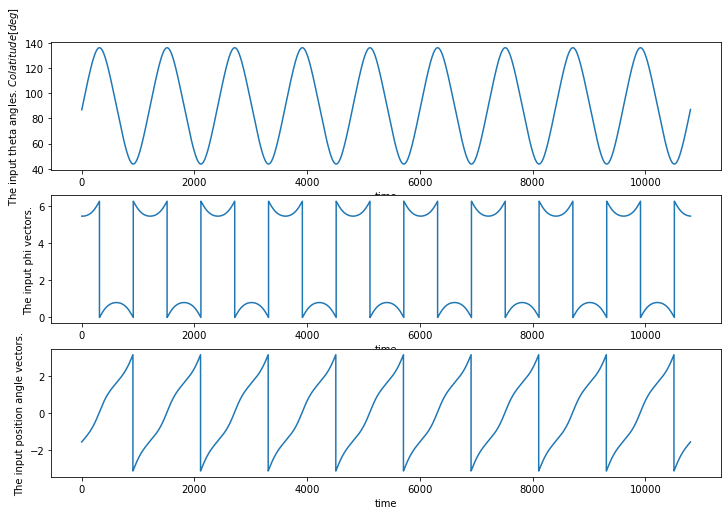

<Figure size 504x360 with 0 Axes>

In [8]:
#tod = data.obs[0]["tod"]
times = tod.local_times()
#####################
# check trajectory
#####################
#pix = tod.cache.reference("pixels_L01_008_QA_078B")
theta, phi, pa = qa.to_angles(tod.read_pntg(detector=detnames[2]))

fig = plt.figure(figsize=[12, 8])    
plt.figure(figsize=(7, 5))
ax = fig.add_subplot(3, 1, 1)
ax.plot(times, np.degrees(theta))#, tod.cache.reference("signal_L01_008_QA_078B")[:num], ".")
ax.set_xlabel("time")#"$Colatitude [deg]$")
ax.set_ylabel("The input theta angles. $Colatitude [deg]$");#"$Signal [ \mu K_{RJ} ]$");

ax = fig.add_subplot(3, 1, 2)
ax.plot(times, phi)#, tod.cache.reference("signal_L01_008_QA_078B")[:num], ".")
ax.set_xlabel("time")#"$Colatitude [deg]$")
ax.set_ylabel("The input phi vectors.");#"$Signal [ \mu K_{RJ} ]$");

ax = fig.add_subplot(3, 1, 3)
ax.plot(times, pa)#, tod.cache.reference("signal_L01_008_QA_078B")[:num], ".")
ax.set_xlabel("time")#"$Colatitude [deg]$")
ax.set_ylabel("The input position angle vectors.");#"$Signal [ \mu K_{RJ} ]$");

In [17]:
# Hpix
toast.todmap.OpPointingHpix(nside=nside, nest=True, mode="IQU").exec(data)
# Make maps
mapmaker = toast.todmap.OpMapMaker(
    nside=nside,
    nnz=3,
    name=name,
    outdir=outdir,
    outprefix=file_name,
    baseline_length=10,
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=1,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


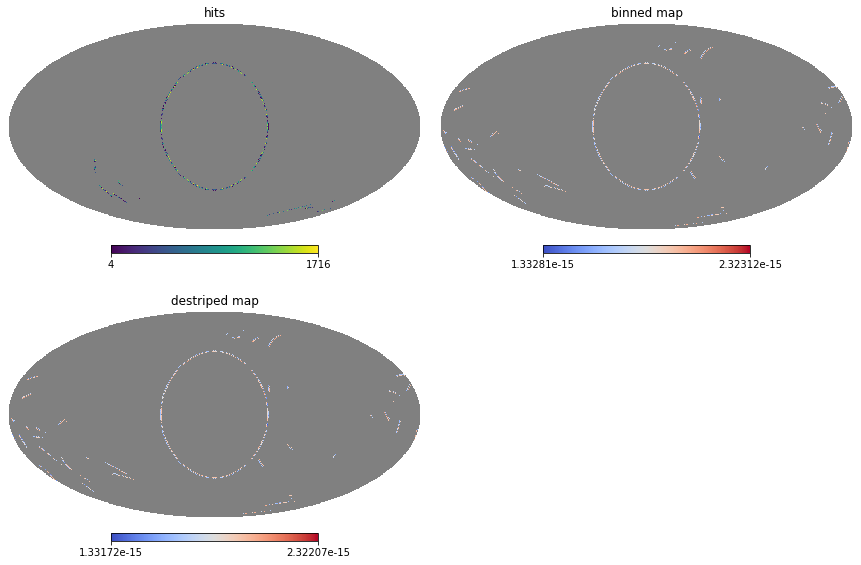

In [18]:
fig = plt.figure(figsize=[12, 8])
hitmap = hp.read_map(outdir+file_name+"hits.fits")
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, sub=[2, 2, 1], title="hits")

binmap = hp.read_map(outdir+file_name+"binned.fits")
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[2, 2, 2], title="binned map", cmap="coolwarm")

destriped = hp.read_map(outdir+file_name+"destriped.fits")
destriped[destriped == 0] = hp.UNSEEN
hp.mollview(destriped, sub=[2, 2, 3], title="destriped map", cmap="coolwarm")
plt.show()    
#fig.savefig("qa.pdf")

In [11]:
#####################
# plot maps
#####################
"""
fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det)
    #print(sky)
    #print(tod.local_times())
    ind = slice(0, 1000)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    ax.plot(times, sky, '.', label="signal", zorder=100)
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)

plt.figure(figsize=[12, 8])
"""

'\nfig = plt.figure(figsize=[12, 8])\nfor idet, det in enumerate(tod.local_dets):\n    sky = tod.local_signal(det)\n    #print(sky)\n    #print(tod.local_times())\n    ind = slice(0, 1000)\n    ax = fig.add_subplot(4, 4, 1 + idet)\n    ax.set_title(det)\n    ax.plot(times, sky, \'.\', label="signal", zorder=100)\nax.legend(bbox_to_anchor=(1.1, 1.00))\nfig.subplots_adjust(hspace=0.6)\n\nplt.figure(figsize=[12, 8])\n'